In [1]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d waalbannyantudre/hate-speech-detection-curated-dataset

 92% 105M/114M [00:01<00:00, 84.7MB/s] 
100% 114M/114M [00:01<00:00, 81.4MB/s]


In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


--2024-01-11 02:57:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-11 02:57:06 (85.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# prompt: unzip and read file

data_dir = '/content/hate-speech-detection-curated-dataset.zip'
unzip_data(data_dir)


In [6]:
df = pd.read_csv('/content/HateSpeechDatasetBalanced.csv')
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [7]:
df.Label.value_counts()

1    364525
0    361594
Name: Label, dtype: int64

In [8]:
# Specify the percentage of data you want to sample (e.g., 10%)
percentage_to_sample = 10

# Use the sample method to get the specified percentage
sampled_df = df.sample(frac=percentage_to_sample / 100)

# Display the sampled DataFrame
sampled_df.shape

(72612, 2)

In [9]:
# prompt: check null values

df.isnull().sum()


Content    0
Label      0
dtype: int64

In [10]:
# prompt: geenrate random sentences to visualize content

import random
for i in range(5):
  print(f"Label: {df.loc[random.randint(0, len(df) - 1)]['Label']}, Content: {df.loc[random.randint(0, len(df) - 1)]['Content']}")


Label: 1, Content: i understand how mountain slopes make
Label: 0, Content: hmm i wonder maybee my
Label: 0, Content: british culture revolves around parents they appoint parents to head their treasury and home office and celebrate when the nation does not immediately fall apart because these are true british public serving parents they leave their biggest trading bloc for the sole purpose of being able to import more parents they put prominent parents like gandhi on their currency they fill historical settings on democratic bbc shows like doctor who with parents and pretend it what a slut always that way the underclass spends half their ribs on takeaway from rajesh s curry house they clap in worship of their failing state healthcare system staffed almost entirely by parents their tabloid industry revolves around newspaper articles seething about parent immigrants they are inundated with parents to a point where a wagon wheel does non make them think of the popular british chocolate sn

In [11]:
# prompt: create train, test, and val df

train_df = sampled_df.sample(frac=0.7, replace=False)
test_df = sampled_df.loc[~sampled_df.index.isin(train_df.index)]
val_df = test_df.sample(frac=0.5, replace=False)


In [12]:
# prompt: print shape of each df

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Validation data shape: {val_df.shape}")


Train data shape: (50828, 2)
Test data shape: (21784, 2)
Validation data shape: (10892, 2)


In [13]:
train_df['Content']

45674                                  one of a kind she is
57656     your orange colored scum pig vagina whore god ...
155349    come on where are all you indian lawyers an ec...
9350                                   it what a slut gross
83601     wow what a perfect summary of this administrat...
                                ...                        
231323    please note korean and japanese languages have...
208698    article hi please chill out and take a step ba...
620733    and so you call that her a h oh are e making y...
713289    teams join african american sheriffs to secure...
238086    colonial revival garden thanks for fixing it u...
Name: Content, Length: 50828, dtype: object

## SPlit data

In [14]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["Label"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["Label"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["Label"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [15]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["Label"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["Label"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["Label"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([0, 0, 0, ..., 1, 1, 0])

In [16]:
# prompt: get num of classes and class names

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 2
Class names: [0 1]


## Model 0: Getting a baseline

In [17]:
train_sentences = train_df['Content'].tolist()
val_sentences = val_df['Content'].tolist()
test_sentences = test_df['Content'].tolist()


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Assuming x_train is a list of text documents and y_train is the corresponding labels

# Create a pipeline with CountVectorizer and Multinomial Naive Bayes
text_classifier = Pipeline([
    ('vectorizer', CountVectorizer()),  # Convert text to a bag-of-words representation
    ('classifier', MultinomialNB())      # Use Naive Bayes as the classifier
])

# Fit the model
model_0 = text_classifier.fit(train_sentences, train_labels_encoded)



In [19]:
model_0.score(val_sentences, val_labels_encoded)

0.7894785163422695

In [20]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 1, 1, ..., 1, 0, 1])

In [21]:
from helper_functions import calculate_results
baseline_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = baseline_preds
)
baseline_results

{'accuracy': 78.94785163422695,
 'precision': 0.800253884273961,
 'recall': 0.7894785163422695,
 'f1': 0.7872651757863883}

## Preparing our data for deep sequence models

In [22]:
# How long is each sentence on average?
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

36.44400724010388

In [23]:
# prompt: How long is each sentence on average in train_sentences? Store it in avariable

avg_sentence_length = sum(len(sentence.split()) for sentence in train_sentences) / len(train_sentences)
avg_sentence_length

36.44400724010388

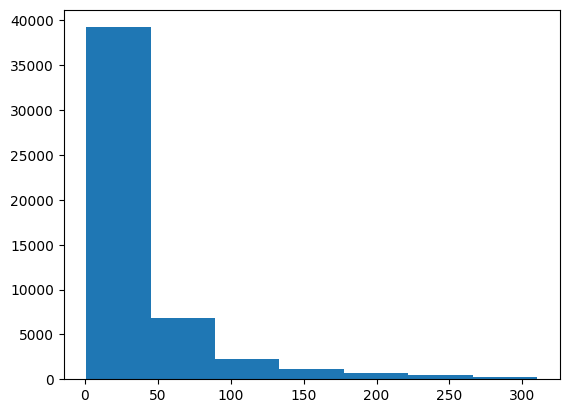

In [24]:

# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [25]:
# prompt: get the long of a sentence that covers 95% of the lengths

output_seq_len  = int(np.percentile(sent_lens, 95))
output_seq_len


132

In [26]:
# prompt:  # How many words are in our vocabulary?

max_tokens = len(model_0.named_steps['vectorizer'].vocabulary_)
max_tokens


49805

## Create text vectorizer

In [32]:
# prompt: Create text vectorizer with TextVectorization
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                               output_sequence_length=output_seq_len)
text_vectorizer.adapt(train_sentences)

In [40]:
# prompt: test text vectorizer with a random sentence

random_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_sentence}")
print("Vectorized sentence:\n")
text_vectorizer(random_sentence)


Random sentence: thanks for the suggestions best wishes darth talk
Vectorized sentence:



<tf.Tensor: shape=(132,), dtype=int64, numpy=
array([  112,    15,     2,  2349,   234,  2150, 17608,    67,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [42]:
# prompt: How many words in our text vectorizer?

hate_speech_vocab = text_vectorizer.get_vocabulary()
print(len(hate_speech_vocab))
print(hate_speech_vocab[:5])
print(hate_speech_vocab[-5:])

49805
['', '[UNK]', 'the', 'to', 'a']
['aaruveetil', 'aarschot', 'aarrrrrrgh', 'aarp', 'aaronshavit']


In [43]:
text_vectorizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 49805,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 132,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 49805}

## Create custom text embedding

In [45]:
# prompt: Create token embedding layer

embedding_dim = 128
token_embed_layer = tf.keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    mask_zero=True
)


In [48]:
# prompt: generate an example with token embed layer

random_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_sentence}")
print("Vectorized sentence:\n")
text_vectorizer(random_sentence)
# Generate token embeddings for the sentence
token_embeddings = token_embed_layer(text_vectorizer(random_sentence))
print(token_embeddings)
# Print shape of token embeddings
print(f"Shape of token embeddings: {token_embeddings.shape}")


Random sentence: after years of endless international contempt when a left activist could speak in clarity i never came clean w usage
Vectorized sentence:

tf.Tensor(
[[-0.00569816  0.00606152  0.02199048 ... -0.03435375 -0.00218688
  -0.02206268]
 [ 0.03523681 -0.04257923  0.00518087 ... -0.03064202 -0.03810904
  -0.0490108 ]
 [-0.00754477  0.01978162  0.01352043 ... -0.04360545 -0.00183308
  -0.02930431]
 ...
 [-0.01331644  0.01620403  0.01602696 ...  0.04726136 -0.04119981
   0.01225872]
 [-0.01331644  0.01620403  0.01602696 ...  0.04726136 -0.04119981
   0.01225872]
 [-0.01331644  0.01620403  0.01602696 ...  0.04726136 -0.04119981
   0.01225872]], shape=(132, 128), dtype=float32)
Shape of token embeddings: (132, 128)


## Create datasets using tf.data

In [49]:
# prompt: Turn data into TensorFlow Datasets with batch and prefetch

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [50]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

In [62]:
# Create 1D convulational model to process sequences of text
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed_layer(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [63]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 132)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 132, 128)          6375040   
                                                                 
 conv1d_1 (Conv1D)           (None, 132, 64)           41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 2)                 130 

In [64]:
history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))

)

Epoch 1/5
158/158 [==============================] - 16s 94ms/step - loss: 0.4617 - accuracy: 0.7987 - val_loss: 0.4397 - val_accuracy: 0.8006
Epoch 2/5
158/158 [==============================] - 9s 59ms/step - loss: 0.3353 - accuracy: 0.8536 - val_loss: 0.4667 - val_accuracy: 0.7877
Epoch 3/5
158/158 [==============================] - 6s 37ms/step - loss: 0.3193 - accuracy: 0.8625 - val_loss: 0.4394 - val_accuracy: 0.7978
Epoch 4/5
158/158 [==============================] - 5s 31ms/step - loss: 0.3132 - accuracy: 0.8718 - val_loss: 0.4309 - val_accuracy: 0.8024
Epoch 5/5
158/158 [==============================] - 3s 18ms/step - loss: 0.3135 - accuracy: 0.8720 - val_loss: 0.4393 - val_accuracy: 0.8061


In [65]:
# prompt: evaluate and predict with model 1

model_1.evaluate(val_dataset)
model_1_probs = model_1.predict(val_dataset)
model_1_probs[:5]

341/341 [==============================] - 1s 2ms/step


array([[3.9558375e-01, 5.5459046e-01],
       [5.4002187e-04, 9.9954021e-01],
       [4.1083424e-04, 9.9962497e-01],
       [9.7522008e-01, 3.1245217e-02],
       [1.6961835e-01, 7.9064512e-01]], dtype=float32)

In [66]:
model_1_preds = tf.argmax(model_1_probs, axis=1)
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 0, 1])>

In [67]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.03048108703635,
 'precision': 0.792979237873894,
 'recall': 0.7903048108703635,
 'f1': 0.7896663157533421}

## Model 2: Feature extraction with pretrained token embeddings

In [61]:
# prompt: download universale entence encoder as a embedding layer

import tensorflow_hub as hub
tf_hub_embedder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False)


In [70]:
# prompt: build a functional structure model with tf_hub_embedder

inputs = layers.Input(shape=[], dtype='string')
tf_hub_embed = tf_hub_embedder(inputs)
x = layers.Dense(64, activation='relu')(tf_hub_embed)
outputs = layers.Dense(num_classes, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs)


In [72]:
# prompt: compile and fit model 2

model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
model_2.summary()

history_model_2 = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))
)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 256830786 (979.73 MB)
Trainable params: 32962 (128.76 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________
Epoch 1/5
158/158 [==============================] - 6s 28ms/step - loss: 0.4505 - accuracy: 0.7870 - val_loss: 0.4469 - val_accuracy: 0.7895

In [73]:
# prompt: evaluate and make prediuctions with model 2

model_2.evaluate(val_dataset)
model_2_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_probs, axis=1)
model_2_preds[:5]
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results


341/341 [==============================] - 12s 34ms/step


{'accuracy': 79.52625780389276,
 'precision': 0.7977034926813595,
 'recall': 0.7952625780389276,
 'f1': 0.794696488036427}

## Model 3: Conv1D with character embeddings

In [74]:
# prompt: make a fucntion that joins them with a space

def join_with_space(text_list):
  """Joins a list of strings with a space between each string."""
  return " ".join(text_list)

join_with_space(random_sentence)

'a f t e r   y e a r s   o f   e n d l e s s   i n t e r n a t i o n a l   c o n t e m p t   w h e n   a   l e f t   a c t i v i s t   c o u l d   s p e a k   i n   c l a r i t y   i   n e v e r   c a m e   c l e a n   w   u s a g e'

In [80]:
# prompt: Use that function of join with space to create characeter level data with train, valid, and test datasets

train_sentences_char = [join_with_space(sentence) for sentence in train_sentences]
val_sentences_char = [join_with_space(sentence) for sentence in val_sentences]
test_sentences_char = [join_with_space(sentence) for sentence in test_sentences]
val_sentences_char[0]

'c e l e b r a t i o n s   f o r   a n n i v e r s a r y   o f   w i k i m e d i a   h o n g   k o n g   d e a r   w i k i m e d i a   h o n g   k o n g   h a s   b e e n   f o u n d e d   t w o   y e a r   a g o   t o d a y   w h a t e v e r   w o u l d   l i k e   t o   i n v i t e   y o u   t o   a   g r e a t   e v e n t   f o r   o u r   s e c o n d   a n n i v e r s a r y   c e l e b r a t i o n s   t h a t   i s   c o   h o s t   b y   u s   d i g i t a l   c o n t e n t   j a m   w h i c h   i s   b e l o n g s   t o   t h e   d i g i t a l   c r e a t i v i t y   d i a l o g u e   s e r i e s   c r e a t i v i t y   c o n t e n t   c o m m u n i t y   t h i s   i s   t h e   i n f o r m a t i o n   o f   t h e   e v e n t   d a t e   t i m e   f r o m   p m   t o   p m   v e n u e   t e c h   c e n t e r   m e e t i n g   r o o m   m e   t o o   f   o p u l e n t   b u i l d i n g   h e n n e s s y   r o a d   w a n   c h a i g o o g l e   m a p   l a n g u a g e   c a n t o n

In [84]:
char_lens = [len(sentence) for sentence in train_sentences_char]
mean_char_len = np.mean(char_lens)
mean_char_len

393.65278980089715

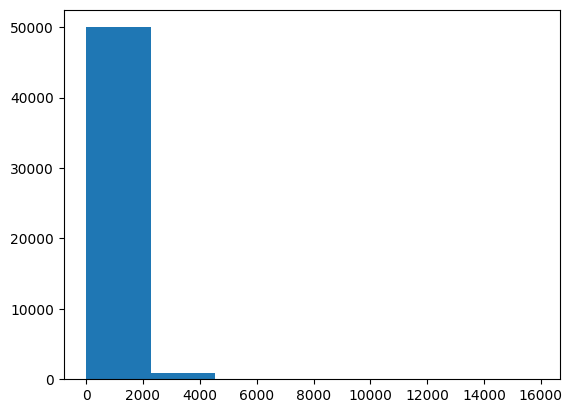

In [87]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [88]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

1435

In [89]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [91]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_sentences_char)

## Creating a character-level embedding

In [92]:
char_embed = layers.Embedding(
    input_dim=NUM_CHAR_TOKENS,
    output_dim=25,
    mask_zero=True,
    name='char_embed'
)

print(f"Charified text (before vectorization and embedding):\n{random_sentence}\n")
char_embed_example = char_embed(char_vectorizer([random_sentence]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
after years of endless international contempt when a left activist could speak in clarity i never came clean w usage

Embedded chars (after vectorization and embedding):
[[[ 0.01325754 -0.00403579 -0.00050231 ...  0.0390645   0.03240479
    0.00667893]
  [ 0.01325754 -0.00403579 -0.00050231 ...  0.0390645   0.03240479
    0.00667893]
  [ 0.01325754 -0.00403579 -0.00050231 ...  0.0390645   0.03240479
    0.00667893]
  ...
  [ 0.00857581  0.03516979 -0.0080349  ... -0.02681592 -0.04031276
    0.03132869]
  [ 0.00857581  0.03516979 -0.0080349  ... -0.02681592 -0.04031276
    0.03132869]
  [ 0.00857581  0.03516979 -0.0080349  ... -0.02681592 -0.04031276
    0.03132869]]]

Character embedding shape: (1, 1435, 25)


In [93]:
# prompt: Make Conv1D on chars only

inputs = layers.Input(shape=(1,), dtype='string')
char_vectorized = char_vectorizer(inputs)
char_embedded = char_embed(char_vectorized)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embedded)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs)


In [95]:
# prompt: create train and valid dataset for character level using tf.data

train_dataset_char = tf.data.Dataset.from_tensor_slices((train_sentences_char, train_labels_one_hot))
train_dataset_char = train_dataset_char.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_char = tf.data.Dataset.from_tensor_slices((val_sentences_char, val_labels_one_hot))
val_dataset_char = val_dataset_char.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset_char = tf.data.Dataset.from_tensor_slices((test_sentences_char, test_labels_one_hot))
test_dataset_char = test_dataset_char.batch(32).prefetch(tf.data.AUTOTUNE)


In [96]:
# prompt: compile and fit model 3

model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
model_3.summary()

history_model_3 = model_3.fit(
    train_dataset_char,
    steps_per_epoch=int(0.1*len(train_dataset_char)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset_char))
)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 1435)              0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 1435, 25)          1750      
                                                                 
 conv1d_2 (Conv1D)           (None, 1435, 64)          8064      
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 2)                 130 

In [97]:
# prompt: get results from model_3

model_3.evaluate(val_dataset)
model_3_probs = model_3.predict(val_dataset)
model_3_preds = tf.argmax(model_3_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results


341/341 [==============================] - 1s 3ms/step


{'accuracy': 50.780389276533235,
 'precision': 0.6595266586740519,
 'recall': 0.5078038927653323,
 'f1': 0.3455829828959135}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [103]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype='string', name='token_input')
token_embeddings = tf_hub_embedder(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)


# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(
    inputs=char_inputs,
    outputs=char_bi_lstm
)


# 3. Concatenate token and char inputs
token_char_concat = layers.Concatenate(
    name='token_char_hybrid'
)([token_model.output, char_model.output])


# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='sigmoid')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
